In [1]:
## curl :  Bash 명령 
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  2844k      0 --:--:-- --:--:-- --:--:-- 2844k


In [2]:
## csv 파일 읽어오기
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [3]:
## 행 및 열 수 가져오기
# 11231행, 26열
df.shape

(11231, 26)

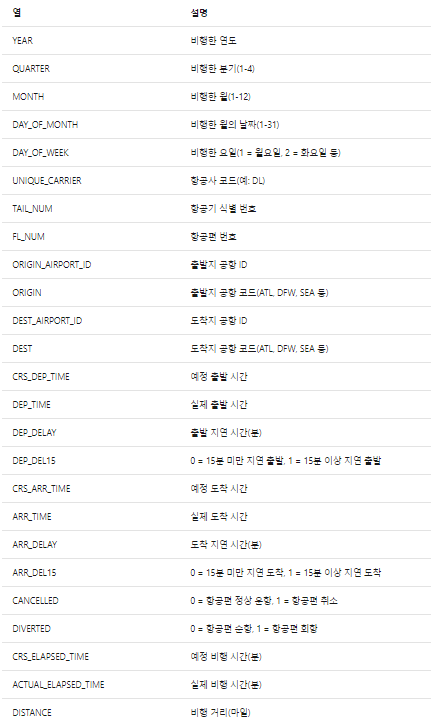
- 26개의 열을 확인하기

In [4]:
## 누락값 확인하기
# True는 어디간에 누락값이 있음을 나타낸다.
df.isnull().values.any()

True

In [5]:
## 누락값 위치 확인하기
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [6]:
## 26번째 열을 제거하기
# 26번쨰열(Unnamed: 25)은 데이터 행 수와 동일한 11231개로 잘못된 것을 확인 가능하다.
# 제거되었는지 확인하기
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [7]:
## 데이터 전처리하기
# 데이터 목표 : 예약하려는 항공편이 정시에 도착할 수 있는지 여부를 예측하고 
# 항공편이 늦게 도착할 가능성이 있으면 다른 항공편을 예약하도록 선택하기
# 연관된 데이터만 남기기
# 비행한 월, 비행한 월의 날짜, 비행한 요일, 출발지 공항 코드, 도착지 공항 코드, 예정 출발 시간, 15분 이상 지연 확인(0, 1로 표현)
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [8]:
## ARR_DEL15 누락값 확인하기
# ARR_DEL15 에 누락값을 확인해본다.
# 0 = 15분 미만 지연 도착, 1 = 15분 이상 지연 도착
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


In [9]:
## 누락값 변경하기
# 누락한 이유는 취소되거나 회항된 항공편으로 늦음으로 분류해서 1로 변경하기
# 누락된 값이 위치해있는 177 ~ 185지정해서 변경되었는지도 확인한다.
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


In [10]:
## 범주화하기전에 확인하기
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


In [11]:
## CRS_DEP_TIME이 범주화되지않아서 변경해주기
# CRS_DEP_TIME 열의 숫자가 0 ~ 23의 범위에 속하는지 확인하기 
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [12]:
## ORIGIN, DEST 숫자로 변경하기 
# ORIGIN 및 DEST 열에서 지표 열을 생성하는 한편, ORIGIN 및 DEST 열 자체를 삭제
# 해당 공항에서 출발했는지 여부를 나타내는 0, 1
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


In [13]:
## train, test 데이터 나누기
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [14]:
train_x.shape

(8984, 14)

In [15]:
test_x.shape

(2247, 14)

In [16]:
## Random Forest 실행하기
# fit으로 실행된다.
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(random_state=13)

In [17]:
## 예측값으로 정확도를 확인하기
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8642634623943035

In [18]:
## 분류 모델 정확도 확인하기(ROC AUC)
# 모델에서 결과에 관계없이 정확히 예측하는 빈도를 정령화해준다.
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [19]:
## 예측 확률 확인하기
# 항공편이 정시에 도착할 확률이 70%, 그렇지않을 확률이 30%
# 두 확룔의 합은 최대 100%이다.
# 위의 확률보다 낮은 이유는 데이터의 불균형때문이다.
# 지연 도착을 나타내는 행보다 정시 도착을 나타내는 행을 더 많이 포함하고 있음.
roc_auc_score(test_y, probabilities[:, 1])

0.7014819895830565

In [20]:
## 성능 확인하기
# 늦게 도착할 것이라고 예측하는것에 있어서는 정확하지않음을 확인할 수 있다.
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1903,   33],
       [ 272,   39]])

In [21]:
## 정밀도 계산하기
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

1.0

In [22]:
## 재현율 계산하기
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.9992012779552716

In [23]:
## 시각화하기위해서 import하기
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

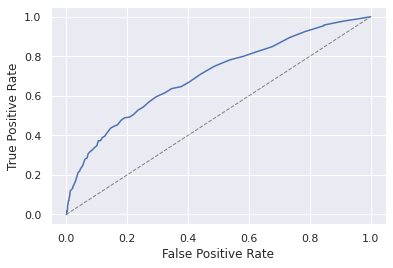

In [24]:
## ROC곡선 그리기
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [25]:
## 정시에 도착할 확률 함수 만들기
# 입력값을 입력하면 항공편이 목적지에 정시에 도착할 확률을 0.0 ~ 1.0의 값으로 반환한다.
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [26]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.88

In [27]:
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.87

In [28]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

0.99

(0.0, 1.0)

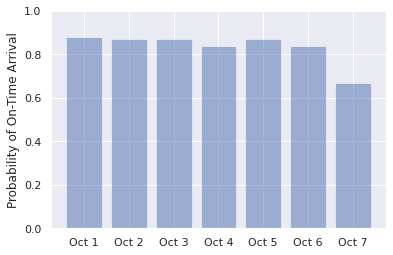

In [29]:
## 확률 계산해보기
# 날짜 범위 동안 JFK에서 ATL로 운항하는 저녁 항공편에 대한 정시 도착 확률을 계산
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))